**Library Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models

***
**Load Dataset**

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')
print(df.shape)
df.head()

(12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df.info() # Check for missing values, data types (categorical vs numerical), objects, bool, etc.

<class 'pandas.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  str    
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType              12330 no

In [ ]:
df.isna().sum()  # Check for missing values (NaNs) in each column 

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

***
**Data Cleaning**

Convert Month to Number in calendar order

In [7]:
df["Month"] = df["Month"].astype(str).str.strip()  # Remove any leading/trailing whitespace

month_mapping = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'June': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
} 
df["Month"] = df["Month"].map(month_mapping)

In [8]:
df["Month"].unique()  # Verify the mapping worked correctly
df["Month"].isna().sum()  # Check for any NaNs after mapping

np.int64(0)

Convert Visitor Type to Number

In [10]:
df["VisitorType"] = df["VisitorType"].astype(str).str.strip()  # Remove any leading/trailing whitespace

visitor_mapping = {
    'Returning_Visitor': 1,
    'New_Visitor': 0,
    'Other': 0
}
df["VisitorType"] = df["VisitorType"].map(visitor_mapping)

In [12]:
df["VisitorType"].unique()  # Verify the mapping worked correctly
df["VisitorType"].isna().sum()  # Check for any NaNs after mapping

np.int64(0)

Convert Boolean columns to int

In [13]:
df["Weekend"] = df["Weekend"].astype(int)
df["Revenue"] = df["Revenue"].astype(int)

Check for NaNs

In [14]:
df.isna().sum()  # Check for missing values in each column

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

***
**Feature & Target for LSTM Regression**

In [16]:
target_column = 'Revenue'

feature_columns = ["Administrative", "Administrative_Duration", "Informational", "Informational_Duration",
                   "ProductRelated", "ProductRelated_Duration", "BounceRates", "ExitRates", "PageValues",
                   "SpecialDay", "Month", "VisitorType", "Weekend"]

df[feature_columns].head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,VisitorType,Weekend
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,1,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,1,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,1,1


***
**Test / Train Split**

In [17]:
X_df = df[feature_columns] # Features
y = df[target_column].values # Target variable

split_index = int(0.8 * len(df)) # 80% for training, 20% for testing
X_train_df = X_df.iloc[:split_index].copy() # Training features
X_test_df = X_df.iloc[split_index:].copy() # Testing features

y_train = y[:split_index] # Training target
y_test = y[split_index:] # Testing target

***
**Scaling**

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df) # Fit on training data
X_test_scaled = scaler.transform(X_test_df) # Transform test data

In [19]:
df.isna().sum() # Final check for missing values
X_train_scaled.shape # Check the shape of the scaled training data


(9864, 13)

(9864, 13) = 9864 rows (training sameple), and 13 features (columns)

***
**Lookback Sequence**

In [20]:
LOOKBACK = 10 # Number of previous time steps to consider

def create_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:(i + lookback)])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, LOOKBACK)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, LOOKBACK)

print("Training data shape:", X_train_seq.shape, y_train_seq.shape)
print("Testing data shape:", X_test_seq.shape, y_test_seq.shape)

Training data shape: (9854, 10, 13) (9854,)
Testing data shape: (2456, 10, 13) (2456,)


***
**5-Layer Model**

In [28]:
norm_layer = layers.Normalization()

In [30]:
LOOKBACK = 10
n_features = X_train_seq.shape[2] # Number of features

model = models.Sequential([
    layers.Input(shape=(LOOKBACK, n_features)), # Input layer
    norm_layer,  # Normalization layer
    layers.LSTM(4, return_sequences=True), # First LSTM layer (4 units)
    layers.Dropout(0.2), # Dropout layer for regularization
    layers.LSTM(4), # Second LSTM layer (4 units)
    layers.Dense(1) # Output layer (regression)
])

norm_layer.adapt(X_train_seq)  # Adapt normalization layer to training data

model.compile( #
    optimizer=tf.keras.optimizers.Adam(), #   Adam optimizer
    loss='mean_squared_error', #   Mean Squared Error loss
    metrics=['mean_absolute_error'] #   Mean Absolute Error metric
)

model.summary()  # Display model architecture

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 10, 13)         │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 10, 4)          │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 4)              │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 464 (1.82 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 27 (112.00 B)

In [31]:
history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
    )

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1162 - mean_absolute_error: 0.2192 - val_loss: 0.1705 - val_mean_absolute_error: 0.2866
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1111 - mean_absolute_error: 0.2206 - val_loss: 0.1674 - val_mean_absolute_error: 0.2982
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1106 - mean_absolute_error: 0.2203 - val_loss: 0.1654 - val_mean_absolute_error: 0.3109
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1103 - mean_absolute_error: 0.2203 - val_loss: 0.1657 - val_mean_absolute_error: 0.3082
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1102 - mean_absolute_error: 0.2196 - val_loss: 0.1645 - val_mean_absolute_error: 0.3245
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1102 - mean_absolute_error: 0.2207 - val_loss: 0.1651 - val_mean_absolute_error: 0.3122
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1100 - mean_absolute_error: 0.2191 - v

***
**Evaluate on the Test Set**

In [32]:
pred = model.predict(X_test_seq).flatten()

mae = mean_absolute_error(y_test_seq, pred)
rmse = np.sqrt(mean_squared_error(y_test_seq, pred))

print("Test MAE:", mae)
print("Test RMSE:", rmse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test MAE: 0.3152455687522888
Test RMSE: 0.4019513670472312


***
**Plot Actual vs Predicted**

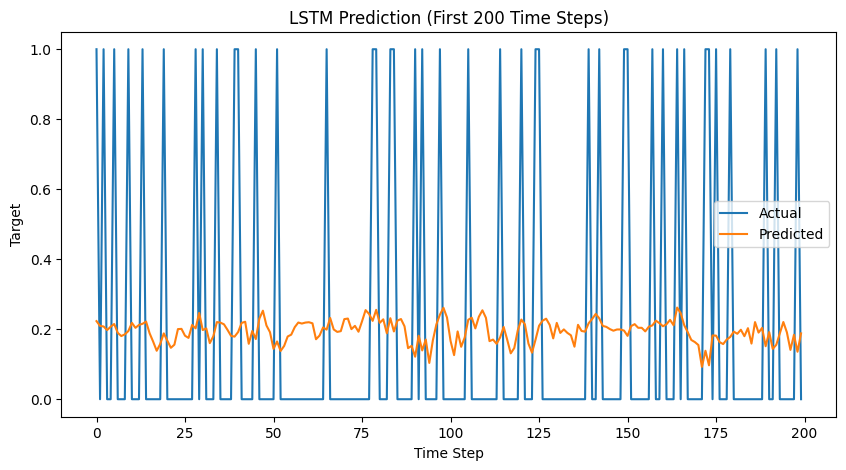

In [34]:
plt.figure(figsize=(10,5))
plt.plot(y_test_seq[:200], label="Actual")
plt.plot(pred[:200], label="Predicted")
plt.title("LSTM Prediction (First 200 Time Steps)")
plt.xlabel("Time Step")
plt.ylabel("Target")
plt.legend()
plt.show()
